# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

Text(0.5, 0, 'Survey Fields')

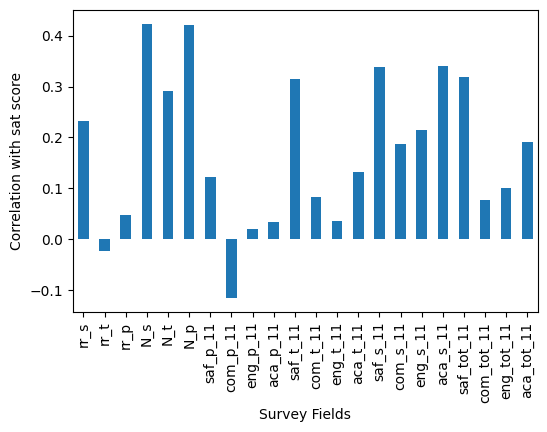

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

combined.corr()["sat_score"][survey_fields].plot.bar()
plt.ylabel("Correlation with sat score")
plt.xlabel("Survey Fields")

Firstly, the "N_s", "N_t" and "N_p" columns all correlate with total enrollment, and we know that total enrollment correlates with sat score, so unsurprisingly those three columns correlate positively with sat score.

The "saf_t_11" and "saf_s_11" columns show how the students and teachers feel about their safety at school, and they both correlate with sat score. This makes sense as you would think a student would perform better in an environment where they felt safe.

Interestingly, "aca_s_11", which is a column of how the student perceives academic standards, correlates well with sat score. However, "aca_t_11" and "aca_p_11", which are columns of how the teachers and parents perceives academic standards, correlate poorly with sat score.

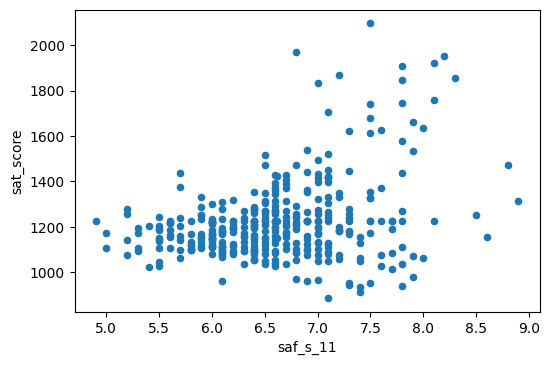

In [25]:
combined.plot.scatter(x="saf_s_11", y="sat_score")

There's a weak positive correlation between sat score and safety, as the highest average sat scores have high safety.

In [47]:
#print(combined[["boro","saf_s_11"]])
print(combined.groupby("boro")["saf_s_11"].mean())

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


The average safety in each borough are similar, all around a value of 6. The highest safety score is in Manhattan and lowest in Brooklyn. 

Text(0.5, 0, 'Race')

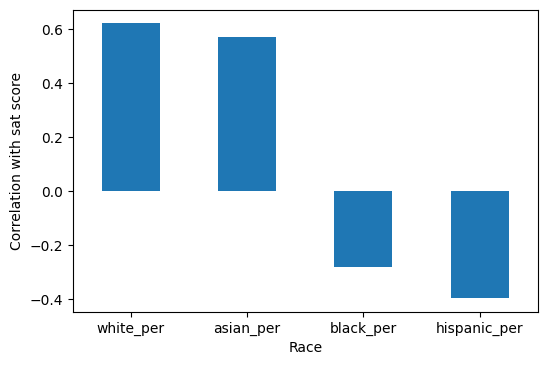

In [54]:
race = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race].plot.bar(rot=0)
plt.ylabel("Correlation with sat score")
plt.xlabel("Race")

The schools with a higher percentage of white and asian students have a strong positive correlation with the sat scores, whereas schools with a higher percentage of black and hispanic students have a negative correlation.

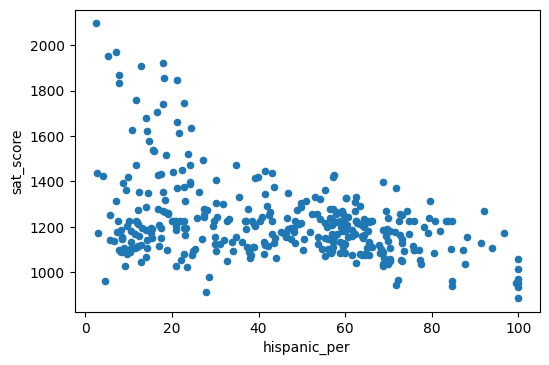

In [55]:
combined.plot.scatter("hispanic_per", "sat_score")


"hispanic_per" correlates negatively with "sat_score" as the lower the percentage of hispanic students, the higher the sat scores.

In [57]:
combined["SCHOOL NAME"][combined["hispanic_per"] > 95]


44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above appear to primarily serve recent immigrants to the U.S. These schools have many students who are learning English, which would explain the lower SAT scores.

In [59]:
low_his = combined[combined["hispanic_per"] < 10]
low_his = low_his["SCHOOL NAME"][low_his["sat_score"] > 1800]
low_his

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Most the schools here specialize in science and technology. They also have an entrance exam the students have to pass to get in. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT.

Text(0.5, 0, 'Gender')

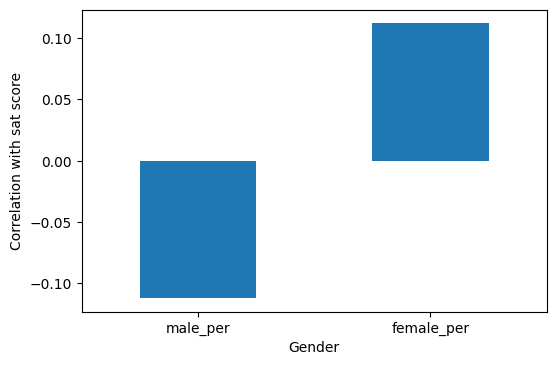

In [63]:
gender = ["male_per", "female_per"]
combined.corr()["sat_score"][gender].plot.bar(rot=0)
plt.ylabel("Correlation with sat score")
plt.xlabel("Gender")

The schools with a higher percentage of males have a weak negative correlation with the sat scores, but schools with a higher percentage of females have a weak positive correlation with sat scores.

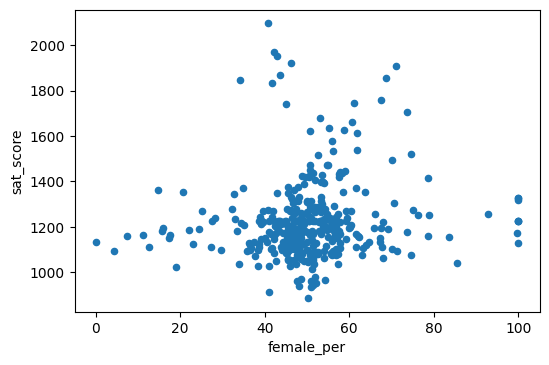

In [64]:
combined.plot.scatter("female_per", "sat_score")

There seems to be no correlation between percentage of female students and the school's sat scores. However, it does show that most schools have an even split of male and female students.

In [66]:
female_sat = combined[combined["female_per"] > 60]
female_sat = female_sat["SCHOOL NAME"][female_sat["sat_score"] > 1700]
female_sat

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools are selective liberal arts schools with very high academic standards.

0.057170813907669614


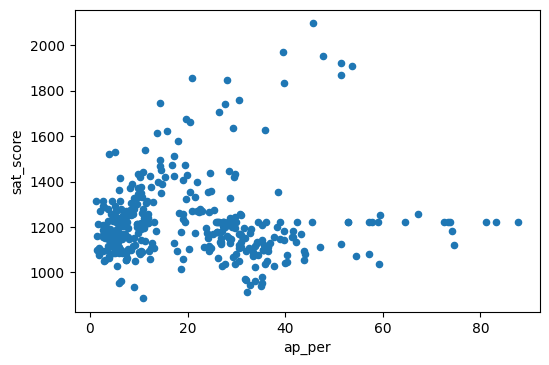

In [76]:
combined["ap_per"] = (combined["AP Test Takers "]/combined["total_enrollment"])*100
combined.plot.scatter("ap_per", "sat_score")
print(combined.corr()["sat_score"]["ap_per"])

There is a weak positive correlation between the percentage of students that take ap exams in a school and the school's sat scores.